In [1]:
!ls

assets	download_data.py  models	    playground.py  train.py
config	load_blender.py   nerf_helpers.py   __pycache__
data	model.py	  playground.ipynb  README.md


The code will run on cpu
Images: (100, 300, 300, 3)
Poses: (100, 4, 4)


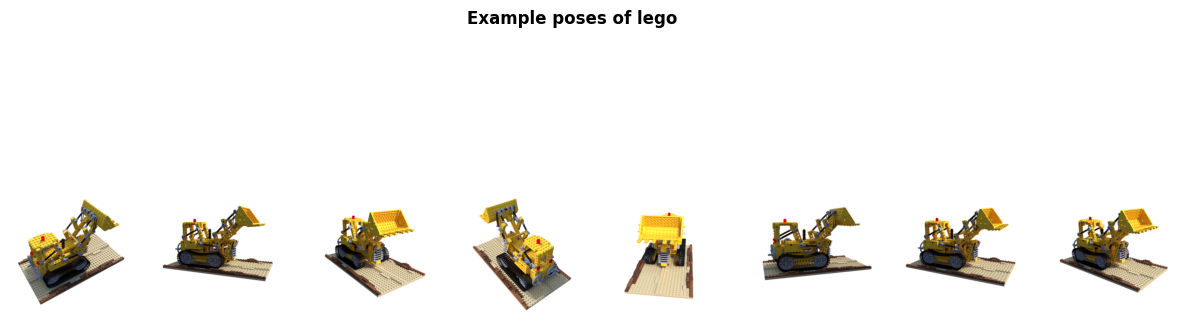

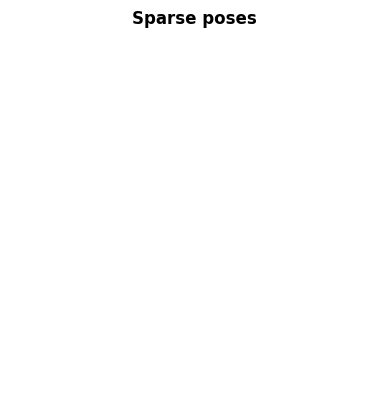

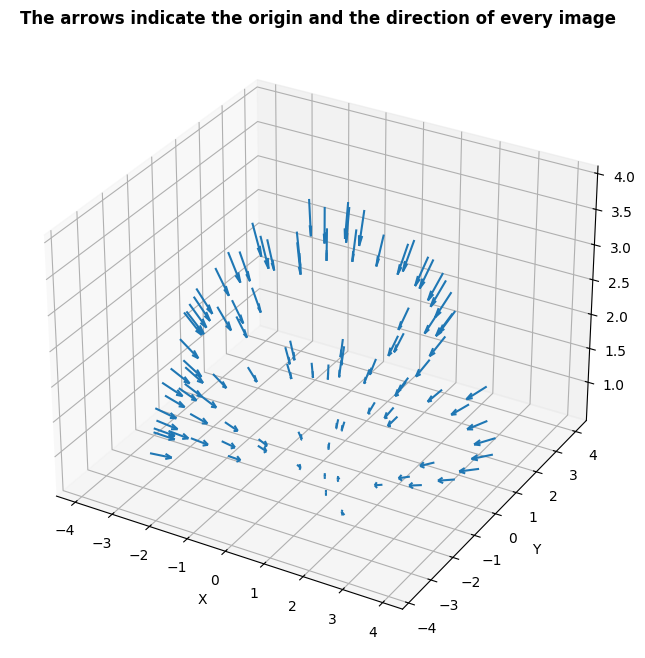

Ray Origin torch.Size([300, 300, 3])
Ray Direction torch.Size([300, 300, 3])
Input Points torch.Size([90000, 8, 3])
Distances Along Ray torch.Size([90000, 8])


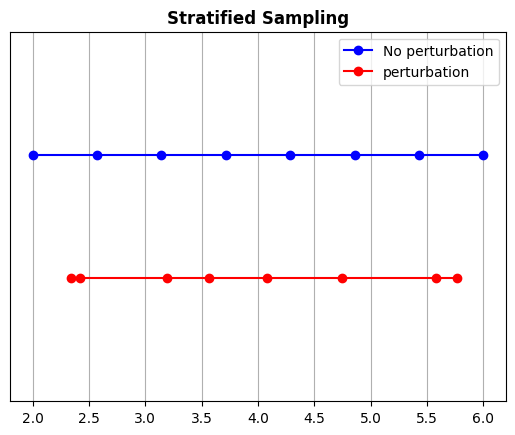

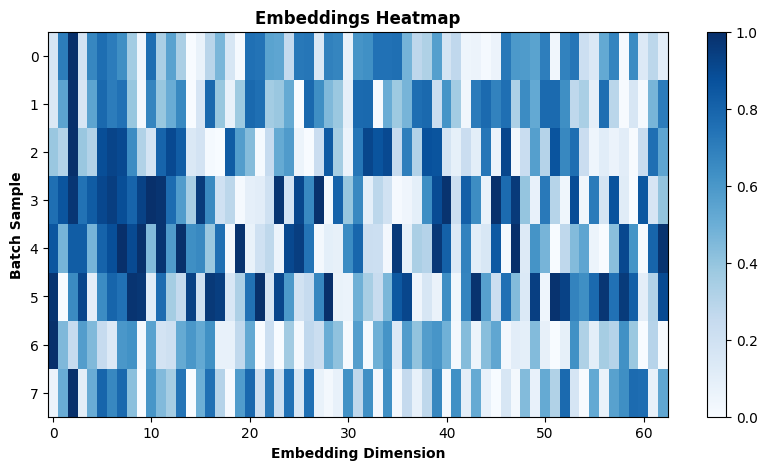

Rendering:   0%|          | 0/40 [01:22<?, ?it/s]


KeyboardInterrupt: 

In [2]:
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import yaml
from pathlib import Path

import torch

from model import NeRF, Embedder
from nerf_helpers import get_rays, sample_stratified, normalize, render_video
from load_blender import load_blender_data


def show(imgs, title=None, fig_titles=None, save_path=None): 

    if fig_titles is not None:
        assert len(imgs) == len(fig_titles)

    fig, axs = plt.subplots(1, ncols=len(imgs), figsize=(15, 5))
    for i, img in enumerate(imgs):
        axs[i].imshow(img)
        axs[i].axis('off')
        if fig_titles is not None:
            axs[i].set_title(fig_titles[i])

    if title is not None:
        plt.suptitle(title, fontweight='bold')
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

    plt.show()


def make_video(images, title='Sparse poses', save_path=None):
    fig = plt.figure()
    ims = []

    if save_path is not None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
        out = cv2.VideoWriter(save_path, fourcc, 5, (images[0].shape[0], images[0].shape[1]))
    for img in images:
        #img_uint8 = (img * 255).astype(np.uint8)
        img_uint8 = (img*255).clip(0,255).astype(np.uint8) 
        im = plt.imshow(img_uint8, animated=True)
        plt.axis('off')
        ims.append([im])
        if save_path is not None:
            out.write(cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR))

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=500)
    plt.title(title, fontweight='bold')

    if save_path is not None:
        out.release()

    plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The code will run on {device}')

scene_name = 'lego' # IMPORTANT: dont change the scene name! You can change it in the training script.
para = yaml.load(Path(f'config/{scene_name}.yaml').read_text(), Loader=yaml.FullLoader)
os.makedirs(f'assets/{scene_name}', exist_ok=True)

"""
NOTE: if the rendering requires too much GPU memory, reduce it to 50 or 100.
The results will not be that good.
"""
TARGET_SIZE = 300

######################################## visualize scene #######################################
images, poses, render_poses, hwf, _ = load_blender_data(para['datadir'], resize=True, target_size=TARGET_SIZE)
height, width, focal = hwf

print('Images:',images.shape)
print('Poses:',poses.shape)

example_imgs = images[np.random.randint(0, images.shape[0], size=8)]
show(example_imgs, title=f'Example poses of {scene_name}', save_path=f'assets/{scene_name}/1.poses.png')
make_video(images, save_path=f'assets/{scene_name}/2.poses_video.mp4')
################################################################################################

"""
Recall that NeRF processes inputs from a field of positions (x,y,z) and view directions ($\theta$,$\phi$). 
To gather these input points, we need to apply inverse rendering to the input images. 
More concretely, we draw projection lines through each pixel and across the 3D space, from which we can draw samples.
To sample points from the 3D space beyond our image, 
we first start from the initial pose of every camera taken in the photo set. 
With some vector math, we can convert these 4x4 pose matrices into a 3D coordinate denoting the origin and a 3D vector indicating the direction. 
The two together describe a vector that indicates where a camera was pointing when the photo was taken.
The code in the cell below illustrates this by drawing arrows that indicate the origin and the direction of every image.
"""

dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
origins = poses[:, :3, -1]

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
_ = ax.quiver(
    origins[..., 0].flatten(),
    origins[..., 1].flatten(),
    origins[..., 2].flatten(),
    dirs[..., 0].flatten(),
    dirs[..., 1].flatten(),
    dirs[..., 2].flatten(), length=0.5, normalize=True
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.title('The arrows indicate the origin and the direction of every image', fontweight='bold')
plt.savefig(f'assets/{scene_name}/3.camera_poses.png', bbox_inches='tight', pad_inches=0)
plt.show()

# get a ray for image 55!
images = torch.from_numpy(images).to(device)
poses = torch.from_numpy(poses).to(device)

testimg_idx = 55
testimg, testpose = images[testimg_idx], poses[testimg_idx]
testpose = poses[testimg_idx]
"""
With this camera pose (testpose), we can now find the projection lines along each pixel of our image. 
Each line is defined by its origin point (x,y,z) and its direction (in this case a 3D vector). 
While the origin is the same for every pixel, the direction is slightly different. 
These lines are slightly deflected off center such that none of these lines are parallel.
"""
ray_origin, ray_direction = get_rays(height, width, focal, testpose)
print('Ray Origin', ray_origin.shape) 
print('Ray Direction',ray_direction.shape)
rays_o = ray_origin.view([-1, 3])
rays_d = ray_direction.view([-1, 3])

############################################ Sampling ##########################################
####### TASK 1: Sample linearly between `near` and `far`
# `near`: how close to the campera
# `far`: how far from the camera

near, far = 2., 6.
n_samples = 8
pts, distances = sample_stratified(rays_o, rays_d, near, far, n_samples, perturb=True)
print('Input Points', pts.shape) # h*w x n_samples x 3
print('Distances Along Ray', distances.shape)

pts_noperturb, distances_noperturb = sample_stratified(rays_o, rays_d, near, far, n_samples, perturb=False)

y_vals = torch.zeros_like(distances)
plt.figure()
plt.plot(distances_noperturb[0].cpu().numpy(), 1 + y_vals[0].cpu().numpy(), 'b-o', label='No perturbation')
plt.plot(distances[0].cpu().numpy(), y_vals[0].cpu().numpy(), 'r-o', label='perturbation')
plt.ylim([-1, 2])
plt.title('Stratified Sampling', fontweight='bold')
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.grid(True)
plt.legend()
plt.savefig(f'assets/{scene_name}/4.sample_stratified.png', bbox_inches='tight', pad_inches=0)
plt.show()
################################################################################################

########################################### Embedding ##########################################

####### Task 2: Complete the implementation of the Embedder
# Create an instance of the Embedder class
d_input = 3  
n_freqs = 10
log_space = True  
embedder = Embedder(d_input, n_freqs, log_space)

points = pts.reshape((-1, 3))
idxs =  torch.linspace(0, pts.shape[0], steps=8, dtype=torch.int)
points = points[idxs]
embeddings = embedder(points).cpu().detach().numpy()

# Visualize the embeddings as a heatmap
embeddings = [normalize(embed) for embed in embeddings]
plt.figure(figsize=(10, 5))
plt.imshow(embeddings, cmap='Blues', aspect='auto')
plt.colorbar()
plt.title('Embeddings Heatmap', fontweight='bold')
plt.xlabel('Embedding Dimension', fontweight='bold')
plt.ylabel('Batch Sample', fontweight='bold')
plt.savefig(f'assets/{scene_name}/5.embeddings_heatmap.png', bbox_inches='tight', pad_inches=0)
plt.show()


################################################################################################
########################################### Rendering ##########################################

origin_embedder = Embedder(3, 10, log_space=True)
embed_origin = lambda x: origin_embedder(x)

views_embedder = Embedder(3, 4, log_space=True)
embed_view = lambda x: views_embedder(x)
d_viewdirs = views_embedder.d_output

####### Task 3: Implement the forward function of the NeRF model
model = NeRF(origin_embedder.d_output, hidden_dim=256, n_layers=8, d_viewdirs=d_viewdirs)
model_fine = NeRF(origin_embedder.d_output, hidden_dim=256, n_layers=8, d_viewdirs=d_viewdirs)

weights = torch.load('models/lego/200000.tar', map_location='cpu')
model.load_state_dict(weights['network_fn_state_dict'])
model_fine.load_state_dict(weights['network_fine_state_dict'])


model.to(device)
model_fine.to(device)

kwargs_sample_stratified = {
    'n_samples': 64,
    'perturb': False,
}

kwargs_sample_hierarchical = {
    'perturb': False,
}

output_path = f'assets/{scene_name}/6.rendered_video.mp4'
pred_frames = render_video(render_poses.to(device), height, width, focal,
    near, far, embed_origin, model, kwargs_sample_stratified, kwargs_sample_hierarchical, para, model_fine, embed_view, 
    output_path=output_path, pbar=True, return_frames=True
)

make_video(pred_frames, title='Rendered video')

################################################################################################

####### Task 4: Render with a constanct viewing direction
### The  task is in the file nerf_helpers and in the fuction: prepare_viewdirs_chunks
constant_viewdir = torch.tensor([1,0,0], device=device)
output_path = f'assets/{scene_name}/7.rendered_video_constant_viewdir.mp4'
pred_frames = render_video(render_poses.to(device), height, width, focal,
    near, far, embed_origin, model, kwargs_sample_stratified, kwargs_sample_hierarchical, para, model_fine, embed_view, 
    output_path=output_path, pbar=True, return_frames=True, constant_viewdir=constant_viewdir
)

make_video(pred_frames, title='Rendered video constant viewing direction')